<a href="https://www.kaggle.com/code/aisuko/denoising-diffusion-probabilistic-models?scriptVersionId=164610234" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

DDPM stands for Denoising Diffusion Probabilistic Models. It is a paper name and also algorithm. Many of models are trained by follwoing DDPM. And here is a pipeline in diffusers. Before we go deeply, here are useful components should be known:

**Pipelines**: A high level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.

**Models**: A popular architectures for training new diffusion models, e.g: Unet.

**Schedulers**: Various techniques for generating images from noise during inference as well as to generate noisy images for training.

In [1]:
%%capture
!pip install diffusers==0.23.1
!pip install Pillow==10.1.0
!pip install tqdm==4.66.1

# Loading the Model

In [2]:
from diffusers import DDPMPipeline

image_pipe=DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.23.1",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

# Generating a Sample

Here, we simply run the pipeline(these pipeline will generate a random initial noise sample and and then iterate the diffusion process).

  0%|          | 0/1000 [00:00<?, ?it/s]

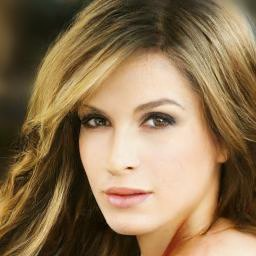

In [3]:
images=image_pipe().images
images[0]

In [4]:
# Here we can see that a Scheduler and a UNet model inside the pipeline.
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.23.1",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

# Models

Instances of the model class are neural networks that take a noisy `sample` as well as a `timestep` as inputs to predict a less noisy output `sample`. Let's load a pre-trained model and play around with it to understand the model API. We will load a simple unconditional image generation model of type `UNet2DModel` which was released with the DDPM paper and for take a look at another checkpoint trained on church images: `google/ddpm-church-256`

In [5]:
# One line load the model configuration and weights
# And we also cache the model weights locally

from diffusers import UNet2DModel

repo_id="google/ddpm-church-256"
model=UNet2DModel.from_pretrained(repo_id)
# The model is a pure PyTorch `torch.nn.Module` class
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsampl

# Configuration of the model

The configuration can be accessed via the `config` attribute and shows all the necessary parameters to define the model architecture.

In [6]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'si

As we can see, the model config is a frozen dictionary. This is to enforce that the configuration will only be used to define the model architecture at instantiation time and not for any attributes that can be changed during inference.

A couple of important config parameters are:

* **sample_size**: defines the `height` and `width` dimension of the input sample.
* **in_channels**: defines the number of input channels of the input sample.
* **down_block_types** and **up_block_types**: define the type of down-and upsampling blocks that are used to create the UNet architecture as was seen in the section above.
* **block_out_channels**: defines the number of output channels of the downsampling blocks, also used in reverse order for the number of input channels of the upsampling blocks.
* **layers_per_block**: defines how many ResNet blocks are present in each UNet block.

In [7]:
# Checking he UNet config looks like
# Here we created a randomly initialized model with the same config as previous one
model_random=UNet2DModel(**model.config)

# here we can also save bothe the model weights as well as the model config
model_random.save_pretrained("unet_demo")

In [8]:
!ls unet_demo

config.json  diffusion_pytorch_model.safetensors


# Inference

First, we need a random gaussian sample in the shape of an image(`batch_size` x `in_channels`x`sample_size`x`sample_size`). 
And we have:
* a `batch` axis because a model can receive multiple random noise
* a `channel` axis becuase each one consists of mutiple channels(such as red-green-blue)
* `sample_size` corresponds to the height and width

In [9]:
import torch

torch.manual_seed(0)

noisy_sample=torch.randn(1, 
                         model.config.in_channels, 
                         model.config.sample_size, 
                         model.config.sample_size)

noisy_sample.shape

torch.Size([1, 3, 256, 256])

We can pass thr noisy sample alongside a `timestep` through the model. The timestep is important to cue the model with "how noisy" the input image is (more noisy in the beginning of the process, less noisy at the end), so the model knows if it's closer to the start or the end of the diffusion process.

As the mentioned above, the model predicts either the slightly less noisy image, the difference between the slightlt less noisy image and the input image or even something else. It is important to carefully read through the model card to know what the model has been trained on. In the case, the model predicts the noise residual(difference between the slightly less noisy iumage and the input image).

In [10]:
with torch.no_grad():
    noisy_residual=model(sample=noisy_sample, timestep=2).sample

The predicted `noisy_residual` has the exact same shape as the input and we use it to compute a slightly less noised image. Let's configm the output shapes match:

In [11]:
noisy_residual.shape

torch.Size([1, 3, 256, 256])

The output shapes should be matched. This is important. I hit lots of issues in the shape of tensors are different. And it is hard to debug.

# Schedulers

**Schedulers** are algorithms wrapped into a Python class. They define the noise schedule which is used to add noise to the model during training, and also define the algorithm to compute the slightly less noisy sample given the model output(here `noisy_residual`). This notebook focuses only on how to use scheduler classes for inference. We will discussed how to use schedulers for training in the future.

It is important to stress here that while models have trainable weights, schedulers are usually parameter-free(in the sense they have no trainable weights) and simply define the algorithm to compute the slightly less noisy sample. Schedulers thus don't inherit from `torch.nn.Module`, but like models they are instantiated by a configuration.

In [12]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)
scheduler.config

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 0),
            ('_use_default_values',
             ['sample_max_value',
              'thresholding',
              'clip_sample_range',
              'steps_offset',
              'timestep_spacing',
              'prediction_type',
              'dynamic_thresholding_ratio']),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

Here are some important parameters:
* `num_train_timesteps`: defines the length of the denoising proces, e.g. how many timesteps are need to process random gaussian noise to a data sample.
* `beta_schedule`: define the type of noise schedule that shall be used for inference and training
* `beta_start` and `beta_end`: define the smallest noise value and highest noise value of the schedule

In [13]:
# It can also be saved and reloaded
scheduler.save_config("demo_scheduler")
# new_scheduler=DDPMScheduler.from_config("demo_scheduler")

All schedulers provide one or multiple `step()` methods that can be used to compute the slightly less noisy image. The `step()` mehod may vary from one scheduler to another, but normally expects at least the model output, the `timestep` and the current `noisy_sample`.

Note that the `step()` method is somewhat of a black box function that "just works". You need to check the actual code to know how exactly the previous noisy sample is computed as defined in the original paper of the scheduler.

In [14]:
less_noisy_sample=scheduler.step(model_output=noisy_residual, timestep=2, sample=noisy_sample).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

Here we can see the computed sample has the exact same shape as the model input, meaning that you are ready to pass it to the model again in a next step.

# Define a Denoising Loop

This loop prints out the (less and less) noisy samples along the way for better visualization in the denoising loop. Let's define the display function that takes care of post-processing the denoised image, convert it to a `PIL.Image` and display it.

In [15]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)
    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [16]:
model.to("cuda")
noisy_sample=noisy_sample.to("cuda")

  5%|▍         | 49/1000 [00:03<01:03, 15.02it/s]

'Image at step 50'

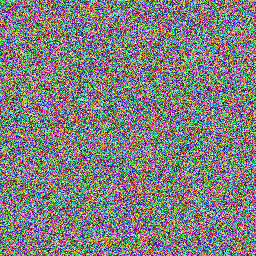

 10%|▉         | 99/1000 [00:06<00:59, 15.05it/s]

'Image at step 100'

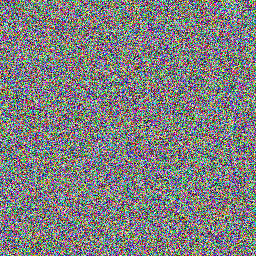

 15%|█▍        | 149/1000 [00:09<00:56, 15.09it/s]

'Image at step 150'

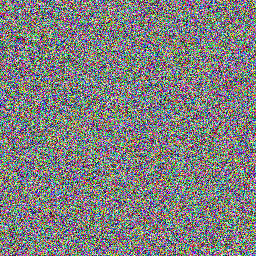

 20%|█▉        | 199/1000 [00:13<00:53, 15.10it/s]

'Image at step 200'

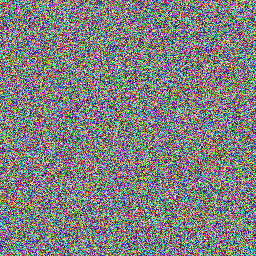

 25%|██▍       | 249/1000 [00:16<00:50, 14.99it/s]

'Image at step 250'

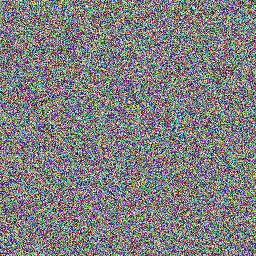

 30%|██▉       | 299/1000 [00:19<00:46, 15.04it/s]

'Image at step 300'

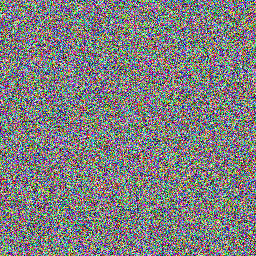

 35%|███▍      | 349/1000 [00:23<00:43, 15.08it/s]

'Image at step 350'

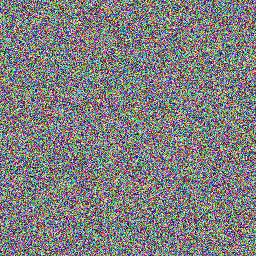

 40%|███▉      | 399/1000 [00:26<00:39, 15.04it/s]

'Image at step 400'

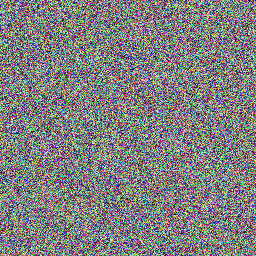

 45%|████▍     | 449/1000 [00:29<00:36, 15.09it/s]

'Image at step 450'

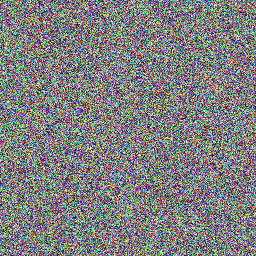

 50%|████▉     | 499/1000 [00:33<00:33, 15.08it/s]

'Image at step 500'

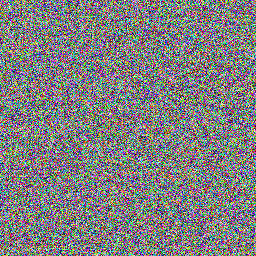

 55%|█████▍    | 549/1000 [00:36<00:29, 15.06it/s]

'Image at step 550'

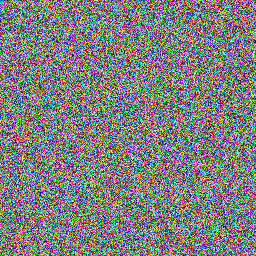

 60%|█████▉    | 599/1000 [00:39<00:26, 15.08it/s]

'Image at step 600'

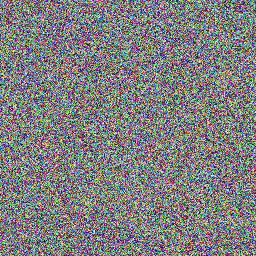

 65%|██████▍   | 649/1000 [00:43<00:23, 15.03it/s]

'Image at step 650'

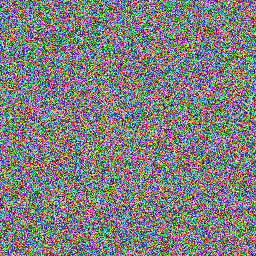

 70%|██████▉   | 699/1000 [00:46<00:19, 15.09it/s]

'Image at step 700'

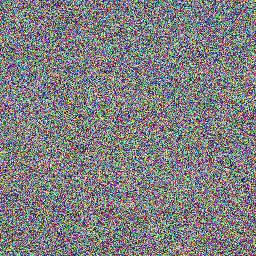

 75%|███████▍  | 749/1000 [00:50<00:16, 15.06it/s]

'Image at step 750'

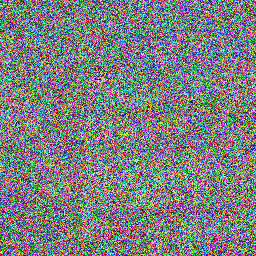

 80%|███████▉  | 799/1000 [00:53<00:13, 15.12it/s]

'Image at step 800'

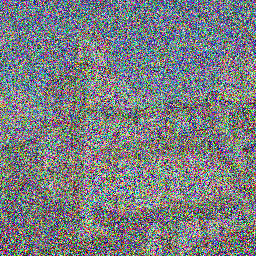

 85%|████████▍ | 849/1000 [00:56<00:10, 15.05it/s]

'Image at step 850'

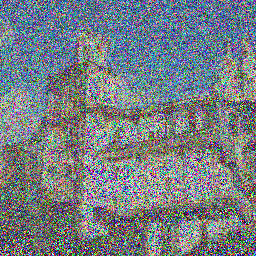

 90%|████████▉ | 899/1000 [01:00<00:06, 15.06it/s]

'Image at step 900'

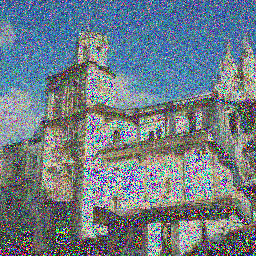

 95%|█████████▍| 949/1000 [01:03<00:03, 15.05it/s]

'Image at step 950'

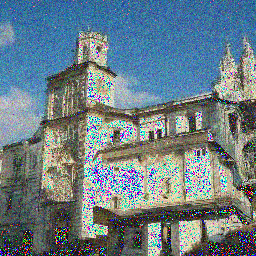

100%|█████████▉| 999/1000 [01:06<00:00, 15.06it/s]

'Image at step 1000'

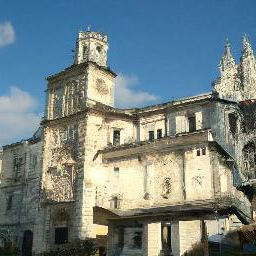

100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]


In [17]:
# Predict the residual of the less noisy sample with the model
# Compute the less noisy sample with the scheduler.
import tqdm

sample=noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise redisual
    with torch.no_grad():
        residual=model(sample,t).sample
    
    # 2. compute less noisy image and set x_t -> x_t-1
    sample =scheduler.step(residual, t, sample).prev_sample
    
    # 3. at every 50th step display the progress
    if (i+1)%50==0:
        display_sample(sample, i+1)